# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 6.0 MB/s 


In [ ]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [ ]:
application_train = pd.read_csv("/content/drive/MyDrive/Anyone-IA/Unidad III/sprint3/application_train.csv")

In [ ]:
application_test = pd.read_csv("/content/drive/MyDrive/Anyone-IA/Unidad III/sprint3/application_test.csv")

### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [ ]:
print(f"The dataset has {application_train.index.shape} observations and {len(application_train.columns)} columns.")

The dataset has (307511,) observations and 122 columns.


In [ ]:
print(f"The dataset has {application_test.index.shape} observations and {len(application_test.columns)} columns.")

The dataset has (48744,) observations and 121 columns.


**The training dataset include the Target**.

2- List all columns in the train dataset


In [ ]:
columns = list(application_train.columns)

In [ ]:
print(f"Columns name: {columns}")

Columns name: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONA

In [ ]:
print(f"Number of columns: {len(columns)}")

Number of columns: 122


3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [ ]:
print(f"Data from the first 5 records:")

application_train.head(6).transpose()

Data from the first 5 records:


,0,1,2,3,4,5
SK_ID_CURR,100002,100003,100004,100006,100007,100008
TARGET,1,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M,M
FLAG_OWN_CAR,N,N,Y,N,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0,99000.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0,490495.5
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5,27517.5


4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [ ]:
print(f"Summary of statistics pertaining to the Target column:")

application_train["TARGET"].describe()

Summary of statistics pertaining to the Target column:


count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [ ]:
print(f"Quantity per label:\n\n {application_train['TARGET'].value_counts()}")

Quantity per label:

 0    282686
1     24825
Name: TARGET, dtype: int64


In [ ]:
Percentage = round(application_train.groupby("TARGET").size()/len(
    application_train["TARGET"])*100,2).sort_values(ascending=False)
    
print(f"Percentage of each value: {Percentage}")

Percentage of each value: TARGET
0    91.93
1     8.07
dtype: float64


Text(0.5, 1.0, 'Target total value count ')

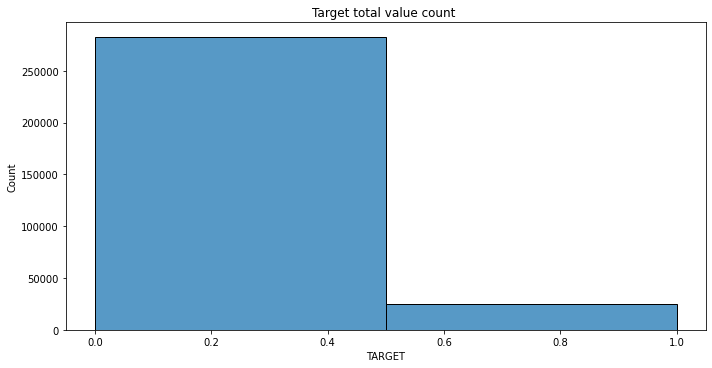

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.histplot(data=application_train, x="TARGET", bins=2)
fig.tight_layout()
plt.title("Target total value count ")

5- Show the number of columns of each data type

In [ ]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

6- For categorical variables, show the number of distinct values in each column (number of labels)

In [ ]:
categorical_features = application_train.select_dtypes(include=['object'])
print(f"Categorical variables:\n {categorical_features.columns}\n")
print(f"Number of categorical variables: {len(categorical_features.columns)}")

Categorical variables:
 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

Number of categorical variables: 16


In [ ]:
list_train = []
for column in categorical_features:
  print(f'Number of labels {column}:{len(dict(categorical_features.groupby(column).size()).keys())}\n')
  print(f'Labels {column}:{dict(categorical_features.groupby(column).size()).keys()}\n')
  list_train += (dict(categorical_features.groupby(column).size()).keys())

Number of labels NAME_CONTRACT_TYPE:2

Labels NAME_CONTRACT_TYPE:dict_keys(['Cash loans', 'Revolving loans'])

Number of labels CODE_GENDER:3

Labels CODE_GENDER:dict_keys(['F', 'M', 'XNA'])

Number of labels FLAG_OWN_CAR:2

Labels FLAG_OWN_CAR:dict_keys(['N', 'Y'])

Number of labels FLAG_OWN_REALTY:2

Labels FLAG_OWN_REALTY:dict_keys(['N', 'Y'])

Number of labels NAME_TYPE_SUITE:7

Labels NAME_TYPE_SUITE:dict_keys(['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied'])

Number of labels NAME_INCOME_TYPE:8

Labels NAME_INCOME_TYPE:dict_keys(['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working'])

Number of labels NAME_EDUCATION_TYPE:5

Labels NAME_EDUCATION_TYPE:dict_keys(['Academic degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special'])

Number of labels NAME_FAMILY_STATUS:6

Labels NAME_FAMILY_STATUS:dict_keys(['Civil marria

In [ ]:
categorical_features_test = application_test.select_dtypes(include=['object'])
print(f"Categorical variables:\n {categorical_features_test.columns}\n")
print(f"Number of categorical variables: {len(categorical_features_test.columns)}")

Categorical variables:
 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

Number of categorical variables: 16


In [ ]:
list_test = []

for column in categorical_features_test:
  print(f'Number of labels {column}:{len(dict(categorical_features_test.groupby(column).size()).keys())}\n')
  print(f'Labels {column}:{dict(categorical_features_test.groupby(column).size()).keys()}\n')
  list_test += (dict(categorical_features_test.groupby(column).size()).keys())

Number of labels NAME_CONTRACT_TYPE:2

Labels NAME_CONTRACT_TYPE:dict_keys(['Cash loans', 'Revolving loans'])

Number of labels CODE_GENDER:2

Labels CODE_GENDER:dict_keys(['F', 'M'])

Number of labels FLAG_OWN_CAR:2

Labels FLAG_OWN_CAR:dict_keys(['N', 'Y'])

Number of labels FLAG_OWN_REALTY:2

Labels FLAG_OWN_REALTY:dict_keys(['N', 'Y'])

Number of labels NAME_TYPE_SUITE:7

Labels NAME_TYPE_SUITE:dict_keys(['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied'])

Number of labels NAME_INCOME_TYPE:7

Labels NAME_INCOME_TYPE:dict_keys(['Businessman', 'Commercial associate', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working'])

Number of labels NAME_EDUCATION_TYPE:5

Labels NAME_EDUCATION_TYPE:dict_keys(['Academic degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special'])

Number of labels NAME_FAMILY_STATUS:5

Labels NAME_FAMILY_STATUS:dict_keys(['Civil marriage', 'Married', 'Separated

In [ ]:
set(list_train) - set(list_test)

{'Maternity leave', 'Unknown'}

**The datatrain has labels that the datatest does not.**

- MATERNITY LEAVE
- UNKNOWN
- XNA en gender

7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [ ]:
PercentageMissing = round((application_train.isnull().sum()/len(application_train))*100,2
      ).sort_values(ascending=False)

print(f"Percentage of missing data for each column:\n {PercentageMissing[0:20]}")
print(f"Number of columns with more than half of their null values: {len(PercentageMissing[PercentageMissing > 40])}")


Percentage of missing data for each column:
 COMMONAREA_MEDI             69.87
COMMONAREA_AVG              69.87
COMMONAREA_MODE             69.87
NONLIVINGAPARTMENTS_MODE    69.43
NONLIVINGAPARTMENTS_AVG     69.43
NONLIVINGAPARTMENTS_MEDI    69.43
FONDKAPREMONT_MODE          68.39
LIVINGAPARTMENTS_MODE       68.35
LIVINGAPARTMENTS_AVG        68.35
LIVINGAPARTMENTS_MEDI       68.35
FLOORSMIN_AVG               67.85
FLOORSMIN_MODE              67.85
FLOORSMIN_MEDI              67.85
YEARS_BUILD_MEDI            66.50
YEARS_BUILD_MODE            66.50
YEARS_BUILD_AVG             66.50
OWN_CAR_AGE                 65.99
LANDAREA_MEDI               59.38
LANDAREA_MODE               59.38
LANDAREA_AVG                59.38
dtype: float64
Number of columns with more than half of their null values: 49


**Analyzing distribution of variables**

1- Show the distribution of credit amounts

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


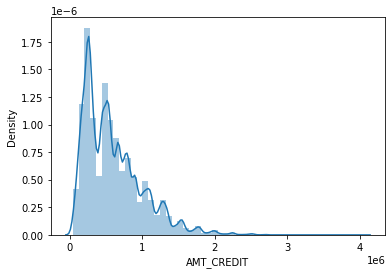

In [ ]:
ax = sns.distplot(application_train['AMT_CREDIT'])

2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

In [ ]:
application_train.groupby("NAME_EDUCATION_TYPE").size()

NAME_EDUCATION_TYPE
Academic degree                     164
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Secondary / secondary special    218391
dtype: int64

In [ ]:
round(application_train.groupby("NAME_EDUCATION_TYPE").size()/len(
    application_train["NAME_EDUCATION_TYPE"])*100,2).sort_values(ascending=False)

NAME_EDUCATION_TYPE
Secondary / secondary special    71.02
Higher education                 24.34
Incomplete higher                 3.34
Lower secondary                   1.24
Academic degree                   0.05
dtype: float64

3- Plot the distribution of ocupation of the loan applicants

In [ ]:
round(application_train.groupby("OCCUPATION_TYPE").size()/len(
    application_train["OCCUPATION_TYPE"])*100,2).sort_values(ascending=False)

OCCUPATION_TYPE
Laborers                 17.95
Sales staff              10.44
Core staff                8.97
Managers                  6.95
Drivers                   6.05
High skill tech staff     3.70
Accountants               3.19
Medicine staff            2.78
Security staff            2.19
Cooking staff             1.93
Cleaning staff            1.51
Private service staff     0.86
Low-skill Laborers        0.68
Waiters/barmen staff      0.44
Secretaries               0.42
Realty agents             0.24
HR staff                  0.18
IT staff                  0.17
dtype: float64

4- Plot the family status of the applicants

In [ ]:
round(application_train.groupby("NAME_FAMILY_STATUS").size()/len(
    application_train["NAME_FAMILY_STATUS"])*100,2).sort_values(ascending=False)


NAME_FAMILY_STATUS
Married                 63.88
Single / not married    14.78
Civil marriage           9.68
Separated                6.43
Widow                    5.23
Unknown                  0.00
dtype: float64

5- Plot the income type of applicants grouped by the target variable

In [ ]:
round(application_train.groupby("NAME_INCOME_TYPE").size()/len(
    application_train["NAME_INCOME_TYPE"])*100,2).sort_values(ascending=False)

NAME_INCOME_TYPE
Working                 51.63
Commercial associate    23.29
Pensioner               18.00
State servant            7.06
Student                  0.01
Unemployed               0.01
Businessman              0.00
Maternity leave          0.00
dtype: float64

In [ ]:
INCOME_TYPE = pd.DataFrame(round(application_train.groupby(["NAME_INCOME_TYPE","TARGET"]).size()/len(
    application_train["NAME_INCOME_TYPE"])*100,2).reset_index(name="Count").sort_values(by="Count", ascending=False))

INCOME_TYPE

,NAME_INCOME_TYPE,TARGET,Count
12,Working,0,46.68
1,Commercial associate,0,21.55
5,Pensioner,0,17.03
7,State servant,0,6.65
13,Working,1,4.95
2,Commercial associate,1,1.74
6,Pensioner,1,0.97
8,State servant,1,0.41
9,Student,0,0.01
0,Businessman,0,0.00


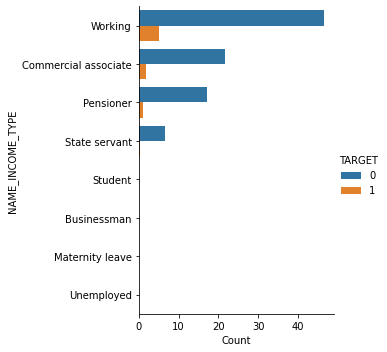

In [ ]:
sns.catplot(y="NAME_INCOME_TYPE",x="Count", hue="TARGET", kind="bar" ,data=INCOME_TYPE)

**The maternity leave and unknown tags have null values, the XNA in gender will be corrected.**

**Graph for each qualitative variable**

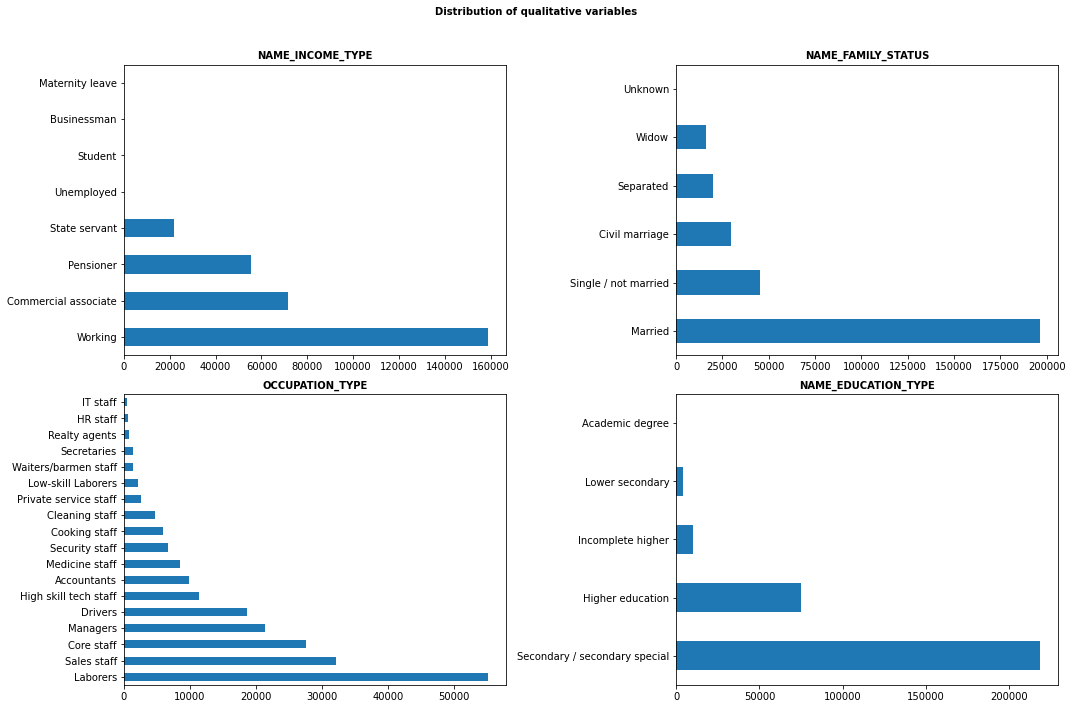

In [ ]:
# Graph for each qualitative variable

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flat
columnas_object = application_train[["NAME_INCOME_TYPE","NAME_FAMILY_STATUS",
                                     "OCCUPATION_TYPE","NAME_EDUCATION_TYPE"]
                                    ].columns

for i, colum in enumerate(columnas_object):
    application_train[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of qualitative variables',
             fontsize = 10, fontweight = "bold");

**We have a very unbalanced dataset since only 8% of the target variable corresponds to an approved loan.
Regarding the applicants, we can see that half obtain their income from a job, the majority are workers, are married (>50%) and have a secondary/special secondary level of study.**

**Of 122 columns, 41 have more than half of their null values.**

**Columns with more than 50% of their null values will be removed.**

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

In [ ]:
numerical_features = application_train.select_dtypes(exclude=['object'])

In [ ]:
numerical_features.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [ ]:
corr_matrix = numerical_features.corr()
print(corr_matrix["TARGET"].sort_values(ascending=False)[0:5])
print("\n------------------------------------\n")
print(corr_matrix["TARGET"].sort_values(ascending=True)[0:5])


TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
Name: TARGET, dtype: float64

------------------------------------

EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64


In [ ]:
valores_unicos = []

for (index, colname) in enumerate(numerical_features):
    valor_unico = {
        colname: len(application_train[colname].unique())}
    
    valores_unicos.append(valor_unico)

In [ ]:
columns_features = []

for i in valores_unicos:
  for j,k in i.items():
    if k > 3:
      columns_features.append(j)

In [ ]:
columns_categorics = []

for i in application_train.columns:
  if i not in columns_features:
    if i != "TARGET":
      columns_categorics.append(i)

In [ ]:
numerical_features = application_train.drop(list(columns_categorics), axis=1)

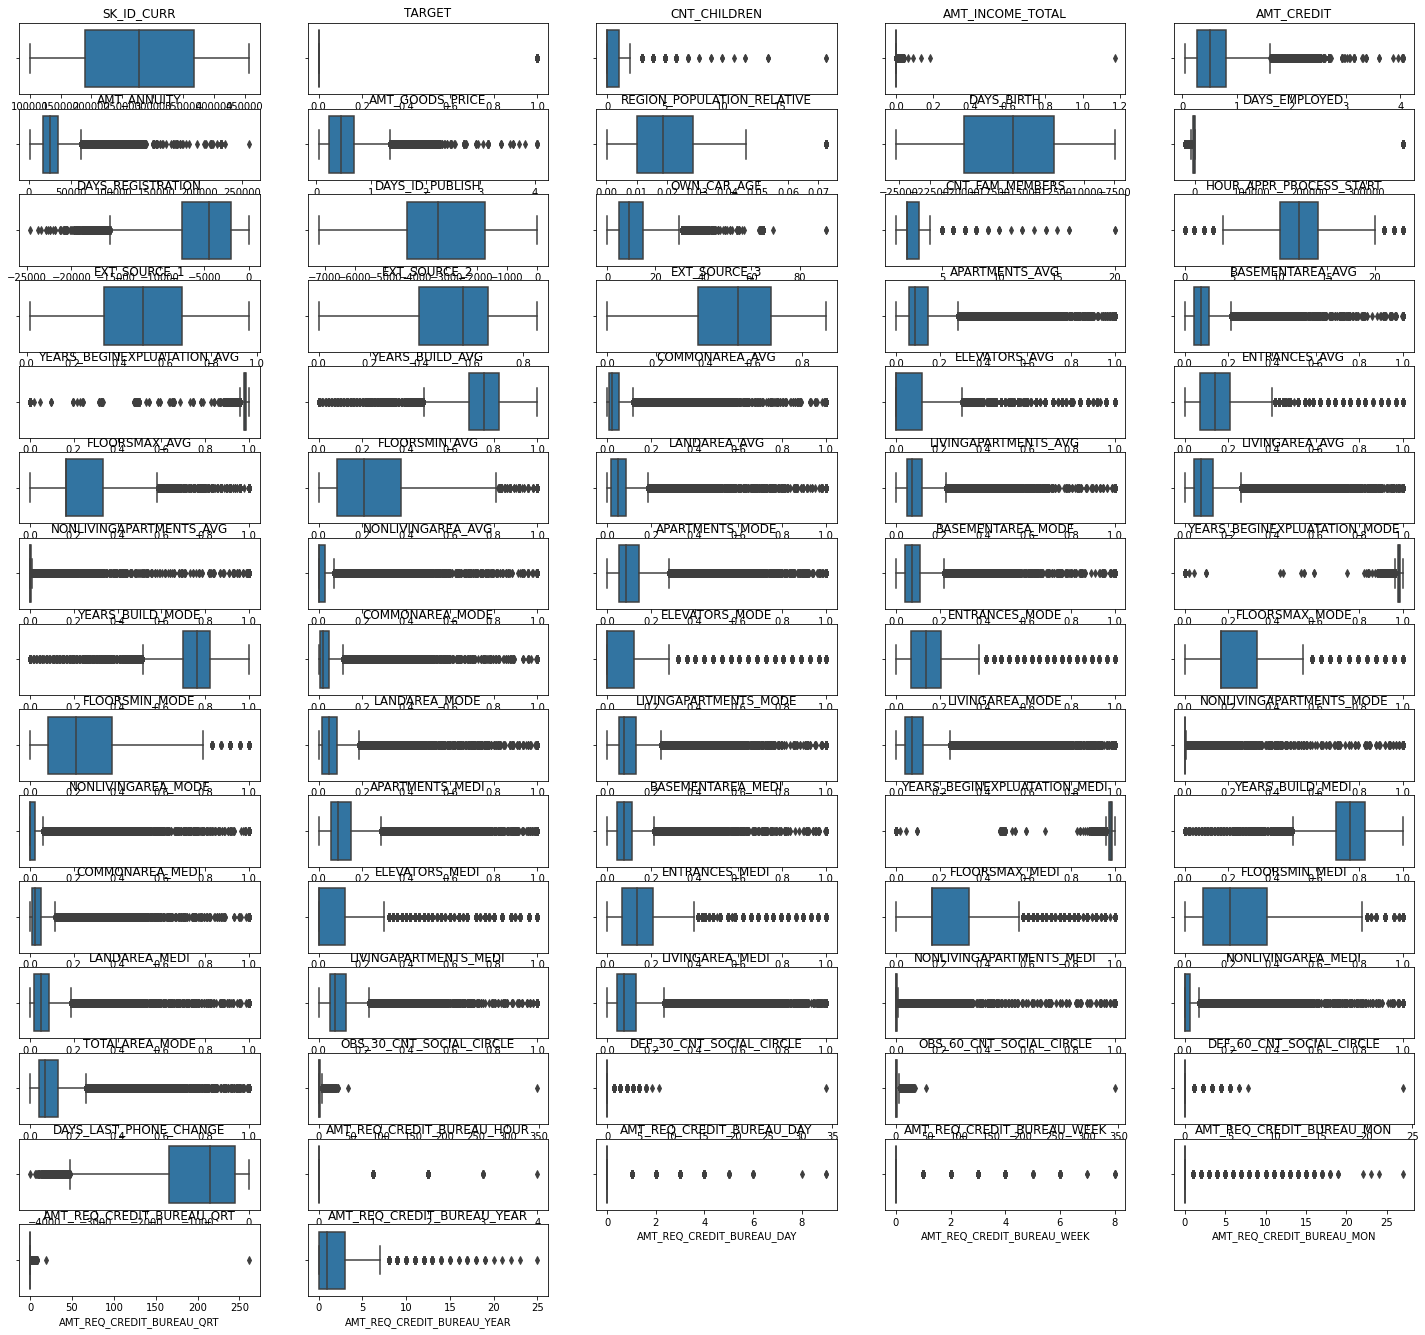

In [ ]:
plt.figure(figsize=(25, 25))
for i, col in enumerate(numerical_features.columns):
    plt.subplot(16, 5, i+1)
    sns.boxplot(data=numerical_features, x=col)
    plt.title(col)

**Tenemos puntos atipicos en AMT_INCOME_TOTAL, OWN_CAR_AGE, DAYS_EMPLOYED.**

In [ ]:
print(f"{application_train['DAYS_EMPLOYED'].value_counts(ascending=False).head(5)}, ")
print(f"{application_train['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(5)}")
print(f"{application_train['AMT_INCOME_TOTAL'].value_counts(ascending=False).head(5)}")
print(f"{application_train['OWN_CAR_AGE'].value_counts(ascending=False).head(5)}")
print(f"{application_train['OWN_CAR_AGE'].sort_values(ascending=False).head(5)}")

 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: DAYS_EMPLOYED, dtype: int64, 
12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
Name: AMT_INCOME_TOTAL, dtype: float64
135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
Name: AMT_INCOME_TOTAL, dtype: int64
7.0    7424
6.0    6382
3.0    6370
8.0    5887
2.0    5852
Name: OWN_CAR_AGE, dtype: int64
294131    91.0
271741    91.0
161390    69.0
39936     65.0
84173     65.0
Name: OWN_CAR_AGE, dtype: float64


**We will transform the positive employee days into NaN and then replace them with the average.
In the case of AMT_INCOME_TOTAL it looks like a missing value so we'll remove it just like in the case of OWN_CAR_AGE.**

In [ ]:
application_train.shape, application_test.shape

((307511, 122), (48744, 121))

In [ ]:
X_train = application_train.copy()
X_test = application_test.copy()

In [ ]:
def preprocessing(data):

#We remove the columns that have more than 40% null values#
  
  columns_drop = []
  for i, col in enumerate(data):
    if data[col].isnull().sum()/len(data) > 0.4:
      columns_drop.append(col)

  data = data.drop(columns_drop, axis=1)
  

#Correction of outliers#
  try:
    data.drop(data[data["CODE_GENDER"] == "XNA"].index, inplace=True)
    data.drop(data[data["NAME_INCOME_TYPE"] == "Maternity leave"].index, inplace=True)
    data.drop(data[data["NAME_FAMILY_STATUS"] == "Unknown"].index, inplace=True)
    data.drop(data[data["AMT_INCOME_TOTAL"] == 117000000].index, inplace=True)
    data.drop(data[data["OWN_CAR_AGE"] == 91].index, inplace=True)
    data["DAYS_EMPLOYED"] = data["DAYS_EMPLOYED"].replace(365243, 0)
  except:
    pass
 
#Correction missing values#
  imputer = SimpleImputer(strategy="mean")
  data_num = data.select_dtypes(exclude=['object'])
  data_num = data_num.drop("SK_ID_CURR", axis=1).reset_index(drop=True)
  columns_num = data_num.columns
  imputer.fit(data_num)
  X = imputer.transform(data_num)
  data_tr = pd.DataFrame(X, columns=columns_num,
                          index=data_num.index)
    
#Encode categorical features#
  Binary_Encoder = []
  One_Hot_Encoder = []

  data_cat = data.select_dtypes(include=['object'])  

  for i, col in enumerate(data_cat):
    if data_cat[col].nunique() == 2:
      Binary_Encoder.append(col)
    else:
      One_Hot_Encoder.append(col)

  data_cat_binary = data_cat[Binary_Encoder].reset_index(drop=True)
  data_cat_OneHot = data_cat[One_Hot_Encoder].reset_index(drop=True)

  #"More than 2 categories"#

  cat_encoder1 = OneHotEncoder()  
  data_cat_1Hot = cat_encoder1.fit_transform(data_cat_OneHot).toarray()
  cat_encoder1_names = cat_encoder1.get_feature_names_out()
  data_1Hot = pd.DataFrame(data_cat_1Hot, columns = cat_encoder1_names)

  #"2 categories"#

  cat_encoder2 = ce.BinaryEncoder(cols=Binary_Encoder,return_df=True)
  data_binary = cat_encoder2.fit_transform(data_cat_binary)

  #"merge df"#
  
  df_cat = data_1Hot.merge(data_binary, left_index=True,
                                    right_index=True).reset_index(drop=True)

#Feature scaling#
  scaler = MinMaxScaler()
  scaler.fit(data_tr)
  data_tr[columns_num] = scaler.transform(data_tr[columns_num])
  data_tr = data_tr.reset_index(drop=True)

#Preprocessed dataframe#    

  df = data_tr.merge(df_cat, left_index=True,
                                    right_index=True).reset_index(drop=True)

  return df


In [ ]:
X_train_p = preprocessing(X_train)

In [ ]:
X_test_p = preprocessing(X_test)

In [ ]:
X_train_p.shape, X_test_p.shape

((307499, 183), (48744, 182))

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [ ]:
y = X_train_p[["TARGET"]]
X = X_train_p.drop("TARGET", axis=1)

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X, y)
y_pred_1 = model.predict(X_test_p)
y_prob_1 = model.predict_proba(X_test_p)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [ ]:
y_prob_1 = pd.DataFrame(y_prob_1, columns=['PREDICTION_0', 'TARGET']
                        ).reset_index(drop=True)

In [ ]:
X_ID =  application_test[["SK_ID_CURR"]].reset_index(drop=True)

In [ ]:
y_LogisticRegression = y_prob_1.merge(X_ID, left_index=True, right_index=True)

In [ ]:
y_LogisticRegression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PREDICTION_0  48744 non-null  float64
 1   TARGET        48744 non-null  float64
 2   SK_ID_CURR    48744 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.1 MB


In [ ]:
y_LogisticRegression['TARGET'] = round(y_LogisticRegression['TARGET']).astype("int32")

In [ ]:
y_LogisticRegression = y_LogisticRegression[["SK_ID_CURR", "TARGET"]]

In [ ]:
y_LogisticRegression.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


In [ ]:
y_LogisticRegression.to_csv('csv_LR.csv', index=False)

3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

**0.50216**

At this point, the model should produce a result around 0.67 

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [ ]:
model2 = RandomForestClassifier()
model2.fit(X, y)
y_pred_2 = model.predict_proba(X_test_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
y_pred_2 = pd.DataFrame(y_pred_2, columns=['PREDICTION_0', 'TARGET']
                        ).reset_index(drop=True)

In [ ]:
y_RandomForestClassifier = y_pred_2.merge(X_ID, left_index=True, right_index=True)

In [ ]:
y_RandomForestClassifier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PREDICTION_0  48744 non-null  float64
 1   TARGET        48744 non-null  float64
 2   SK_ID_CURR    48744 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.1 MB


In [ ]:
y_RandomForestClassifier['TARGET'] = round(y_RandomForestClassifier['TARGET']).astype("int32")

In [ ]:
y_RandomForestClassifier = y_RandomForestClassifier[["SK_ID_CURR", "TARGET"]]

In [ ]:
y_RandomForestClassifier.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


In [ ]:
y_RandomForestClassifier.to_csv('csv_RFC.csv', index=False)

3- Load the predictions to the competition. Report the private score here.

**0.50216**

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

In [ ]:
### Complete in this cell: Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier
example_hyperparameter_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200]
}
clf = RandomizedSearchCV(model2, example_hyperparameter_grid, random_state=0)
search = clf.fit(X, y)
search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
model2 = RandomForestClassifier(bootstrap= False,
                                max_depth= 50,
                                max_features= 'auto',
                                min_samples_leaf= 1,
                                min_samples_split= 5,
                                n_estimators= 100)
model2.fit(X, y)
y_pred_3 = model.predict_proba(X_test_p) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
y_pred_3 = pd.DataFrame(y_pred_3, columns=['PREDICTION_0', 'TARGET']
                        ).reset_index(drop=True)

In [ ]:
y_RandomizedSearch = y_pred_3.merge(X_ID, left_index=True, right_index=True)

In [ ]:
y_RandomizedSearch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PREDICTION_0  48744 non-null  float64
 1   TARGET        48744 non-null  float64
 2   SK_ID_CURR    48744 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.1 MB


In [ ]:
y_RandomizedSearch['TARGET'] = round(y_RandomizedSearch['TARGET']).astype("int32")

In [ ]:
y_RandomizedSearch = y_RandomizedSearch[["SK_ID_CURR", "TARGET"]]

In [ ]:
y_RandomizedSearch.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


In [ ]:
y_RandomizedSearch.to_csv('csv_RS.csv', index=False)

3- Load the predictions to the competition. Report the private score here.

**0.50216**

4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
### Complete in this cell: train a LightGBM model


### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.